In [1]:
using DataFrames, Dates, Plots
using Turing, DifferentialEquations, FillArrays, StatsPlots, LinearAlgebra, Random, Statistics, CSV
Random.seed!(12345)
# 1. Load the data into a DataFrame
data = CSV.File("../julia experiments/Data/GB_ENG.csv") |> DataFrame

# 2. Filter out any rows with missing values in the relevant columns
filtered_data = dropmissing(data, [:date, :new_confirmed, :new_deceased, :new_hospitalized_patients, :current_ventilator_patients, :population])

# 3. Convert the 'date' column to Julia Date type
filtered_data.date = Date.(filtered_data.date)

894-element Vector{Date}:
 2020-04-02
 2020-04-03
 2020-04-04
 2020-04-05
 2020-04-06
 2020-04-07
 2020-04-08
 2020-04-09
 2020-04-10
 2020-04-11
 ⋮
 2022-09-04
 2022-09-05
 2022-09-06
 2022-09-07
 2022-09-08
 2022-09-09
 2022-09-10
 2022-09-11
 2022-09-12

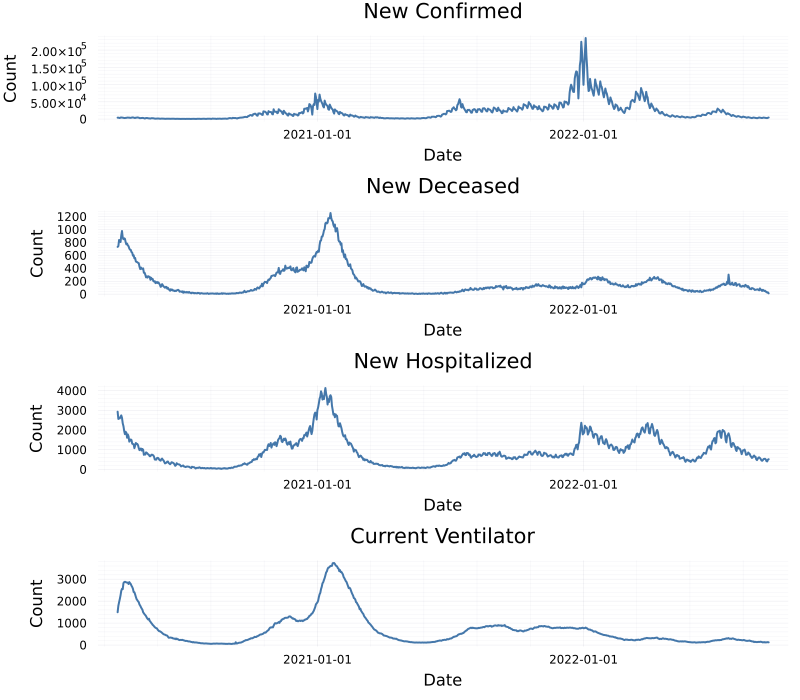

In [2]:
theme(:bright)
# 5. Plot all the columns on separate subplots in one figure
plot(
    filtered_data.date, 
    [filtered_data.new_confirmed, 
     filtered_data.new_deceased, 
     filtered_data.new_hospitalized_patients, 
     filtered_data.current_ventilator_patients], 
    
    layout = (4, 1), 
    size = (800, 700),
    legend = false,
    title = ["New Confirmed" "New Deceased" "New Hospitalized" "Current Ventilator"],
    ylabel = ["Count" "Count" "Count" "Count"],
    xlabel = "Date",
    lw = 2
)

In [3]:
data = DataFrame(
    date = filtered_data.date,
    new_confirmed = filtered_data.new_confirmed,
    new_deceased = filtered_data.new_deceased,
    new_hospitalized_patients = filtered_data.new_hospitalized_patients,
    current_ventilator_patients = filtered_data.current_ventilator_patients
)

data

Row,date,new_confirmed,new_deceased,new_hospitalized_patients,current_ventilator_patients
,Date,Int64,Int64,Int64,Int64
1,2020-04-02,4097,731,2932,1494
2,2020-04-03,4102,743,2564,1788
3,2020-04-04,3405,838,2593,1950
4,2020-04-05,3094,829,2592,2097
5,2020-04-06,4407,806,2679,2264
6,2020-04-07,4605,909,2744,2472
7,2020-04-08,4315,977,2619,2561
8,2020-04-09,4076,875,2340,2546
9,2020-04-10,3590,850,2196,2820


In [4]:
# t = collect(1:length(data.new_confirmed))

# y_cases = data.new_confirmed

# # Standardize the time series
# t_min, t_max = extrema(t)
# x = (t .- t_min) ./ (t_max - t_min)
# y_cases = y_cases .- mean(y_cases)

# # Define cyclic features
# freqs = 1:5  # For now, considering 10 frequencies, this can be adjusted
# num_freqs = length(freqs)
# cyclic_features = hcat(sinpi.(2 .* freqs' .* x), cospi.(2 .* freqs' .* x))

# # Probabilistic model definition
# @model function decomp_model(t, c, op)
#     α ~ Normal(0, 10)
#     βt ~ Normal(0, 2)
#     βc ~ MvNormal(Zeros(size(c, 2)), I)
#     σ ~ truncated(Normal(0, 0.1); lower=0)
#     cyclic = c * βc
#     trend = α .+ βt .* t
#     μ = op(trend, cyclic)
#     y ~ MvNormal(μ, σ^2 * I)
#     return (; trend, cyclic)
# end

# # Sampling
# chain = sample(decomp_model(x, cyclic_features, +) | (; y=y_cases), NUTS(), 2000)

In [5]:
function covid_model!(du, u, p, t)
    # Variables
    S, E, Ia, Is, V, R, D = u
    
    # Parameters
    β, σ, γa, γs, ρ, α, ν, δ, ω, p_asymptomatic = p
    
    # Differential Equations
    du[1] = -β * S * (Ia + Is) + ω * R                 # dS/dt
    du[2] = β * S * (Ia + Is) - σ * E                  # dE/dt
    du[3] = p_asymptomatic * σ * E - γa * Ia           # dIa/dt
    du[4] = (1 - p_asymptomatic) * σ * E - γs * Is - ρ * Is # dIs/dt
    du[5] = ρ * Is - (α + ν) * V                       # dV/dt
    du[6] = γa * Ia + γs * Is + (1 - δ) * α * V - ω * R # dR/dt
    du[7] = δ * α * V + ν * V                          # dD/dt
end

covid_model! (generic function with 1 method)

In [6]:
# Define initial conditions
population = 56.29e6
initial_infections = 100
S0 = population - initial_infections
E0 = initial_infections
Ia0 = 0.4 * initial_infections  # Assuming 40% become asymptomatic
Is0 = 0.6 * initial_infections  # 60% become symptomatic
V0 = 0
R0 = 0
D0 = 0
u0 = [S0, E0, Ia0, Is0, V0, R0, D0]

7-element Vector{Float64}:
   5.62899e7
 100.0
  40.0
  60.0
   0.0
   0.0
   0.0

In [15]:
# Define time span for the simulation
tspan = (0.0, 50.0)  # Simulate for 365 days

# Define parameter values (you can adjust these as needed)
params = [0.5, 1/5, 0.1, 0.1, 0.05, 0.02, 0.01, 0.005, 0.01, 0.4]

10-element Vector{Float64}:
 0.5
 0.2
 0.1
 0.1
 0.05
 0.02
 0.01
 0.005
 0.01
 0.4

In [16]:
# Solve the ODE system
prob = ODEProblem(covid_model!, u0, tspan, params)
sol = solve(prob, Rodas5(), reltol=1e-8, abstol=1e-8)

retcode: Success
Interpolation: specialized 4rd order "free" stiffness-aware interpolation
t: 411-element Vector{Float64}:
  0.0
  7.08647885853216e-8
  4.216725075048196e-7
  2.1096598893275637e-6
  6.197372707929912e-6
  1.2392898272092254e-5
  2.0262957086487134e-5
  3.038436561822476e-5
  4.2604993312141674e-5
  5.711882950641537e-5
  ⋮
 43.093678272873454
 43.97357553707261
 44.87981842833383
 45.814310819370014
 46.77895341516224
 47.77563889840776
 48.80624829191376
 49.87265062301423
 50.0
u: 411-element Vector{Vector{Float64}}:
 [5.62899e7, 100.0, 40.0, 60.0, 0.0, 0.0, 0.0]
 [5.6289700551758766e7, 299.4482384064612, 40.00000084881378, 60.000001060626296, 2.125943669082133e-7, 7.086478908483085e-7, 7.608054687298305e-17]
 [5.628871321713139e7, 1286.7828101309879, 40.00002170410591, 60.000031291141134, 1.2650177388689014e-6, 4.2167258370987744e-6, 2.6937869415698053e-15]
 [5.628396266071067e7, 6037.337994534065, 40.00050947694144, 60.000757886406376, 6.329006227223031e-6, 2.1096

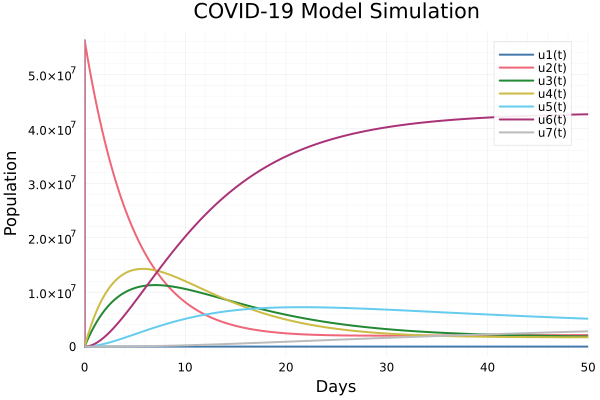

In [17]:
plot(sol, xlabel="Days", ylabel="Population", title="COVID-19 Model Simulation", lw=2)

In [19]:
using CairoMakie

function plot_covid_simulation(sol)
    fig = Figure(resolution = (800, 400), backgroundcolor = :white)
    
    ax = Axis(fig[1, 1], xlabel = "Days", ylabel = "Population", title = "COVID-19 Model Simulation")
    
    # Plot each compartment
    lines!(ax, sol.t, sol[1,:], color = :blue, linewidth = 2, label = "Susceptible")
    lines!(ax, sol.t, sol[2,:], color = :cyan, linewidth = 2, label = "Exposed")
    lines!(ax, sol.t, sol[3,:], color = :yellow, linewidth = 2, label = "Asymptomatic Infectious")
    lines!(ax, sol.t, sol[4,:], color = :red, linewidth = 2, label = "Symptomatic Infectious")
    lines!(ax, sol.t, sol[5,:], color = :orange, linewidth = 2, label = "Ventilated")
    lines!(ax, sol.t, sol[6,:], color = :green, linewidth = 2, label = "Recovered")
    lines!(ax, sol.t, sol[7,:], color = :black, linewidth = 2, label = "Deceased")
    
    # Add legend
    axislegend(ax, position = :rt, labelsize = 10)

    return fig
end

fig = plot_covid_simulation(sol)
save("covid_simulation.png", fig)  # To save the figure


In [39]:
# Extract the first 3 months of data as training data
end_training_date = first(data.date) + Dates.Month(3)
training_data = filter(row -> row.date <= end_training_date, data)
testing_data = filter(row -> row.date > end_training_date, data)

Row,date,new_confirmed,new_deceased,new_hospitalized_patients,current_ventilator_patients
,Date,Int64,Int64,Int64,Int64
1,2020-07-03,536,27,146,202
2,2020-07-04,385,31,120,186
3,2020-07-05,544,25,131,190
4,2020-07-06,664,35,150,188
5,2020-07-07,565,26,148,178
6,2020-07-08,682,23,141,164
7,2020-07-09,688,35,136,167
8,2020-07-10,524,23,104,162
9,2020-07-11,433,20,97,152


In [40]:
training_data

Row,date,new_confirmed,new_deceased,new_hospitalized_patients,current_ventilator_patients
,Date,Int64,Int64,Int64,Int64
1,2020-04-02,4097,731,2932,1494
2,2020-04-03,4102,743,2564,1788
3,2020-04-04,3405,838,2593,1950
4,2020-04-05,3094,829,2592,2097
5,2020-04-06,4407,806,2679,2264
6,2020-04-07,4605,909,2744,2472
7,2020-04-08,4315,977,2619,2561
8,2020-04-09,4076,875,2340,2546
9,2020-04-10,3590,850,2196,2820


In [80]:
start_date = first(training_data.date)
end_date = last(training_data.date)



2020-07-02

In [91]:
using Dates
start_date = Date(2020, 4, 2)
end_date = Date(2020, 7, 2)

days_difference = end_date - start_date

tspan = (0, days_difference.value)

(0, 91)

In [92]:
# Initial conditions and tspan
population = 56.29e6
p_asymptomatic = 0.4
S0 = population - (training_data.new_confirmed[1] + training_data.current_ventilator_patients[1])
E0 = training_data.new_confirmed[1]
Ia0 = p_asymptomatic * training_data.new_confirmed[1]
Is0 = (1 - p_asymptomatic) * training_data.new_confirmed[1]
V0 = training_data.current_ventilator_patients[1]
D0 = training_data.new_deceased[1]
R0 = training_data.new_confirmed[1] - Ia0 - Is0 - V0 - D0

u0 = [S0, E0, Ia0, Is0, V0, R0, D0]



7-element Vector{Float64}:
     5.6284409e7
  4097.0
  1638.8000000000002
  2458.2
  1494.0
 -2225.0
   731.0

In [93]:
@model function covid_inference(training_data, prob)
    # Known parameter
    σ = 1/5

    # Prior distributions for parameters to infer
    β ~ LogNormal(0, 5)
    γa ~ Beta(2 + 1e-5, 2 + 1e-5)
    γs ~ Beta(2 + 1e-5, 2 + 1e-5)
    ρ ~ Beta(1 + 1e-5, 5 + 1e-5)
    α ~ Beta(2 + 1e-5, 3 + 1e-5)
    ν ~ Beta(2 + 1e-5, 3 + 1e-5)
    δ ~ Beta(2 + 1e-5, 2 + 1e-5)
    ω ~ Uniform(0, 3)
    p_asymptomatic ~ Beta(2 + 1e-5, 3 + 1e-5)

    # Parameters for ODE
    params = [β, σ, γa, γs, ρ, α, ν, δ, ω, p_asymptomatic]

    # Solve the ODE system
    predicted = solve(prob, Rodas5(); p=params, saveat=Dates.value.(training_data.date))

    # Observations
    for i in 1:nrow(training_data)
        predicted_Is = max(predicted[i, 4], 0.0)
        predicted_V = max(predicted[i, 5], 0.0)

        training_data.new_hospitalized_patients[i] ~ Poisson(predicted_Is * ρ)
        training_data.current_ventilator_patients[i] ~ Poisson(predicted_V)
        training_data.new_confirmed[i] ~ Poisson(predicted_Is + predicted_V)
        training_data.new_deceased[i] ~ Poisson(δ * α * predicted_V + ν * predicted_V)
    end

    return nothing
end

# Using the model
model = covid_inference(training_data, prob)

# Sample 3 independent chains.
chain = sample(model, NUTS(), MCMCSerial(), 1000, 3; progress=false)


BoundsError: BoundsError: attempt to access 7-element Vector{Float64} at index [8]

In [69]:
# # Solve the ODE system
# prob = ODEProblem(covid_model!, u0, tspan, params)
# sol = solve(prob, Rodas5())

In [70]:
# length(sol.t)


In [71]:
# Sample from the posterior
chain = sample(covid_inference(training_data), NUTS(), 1000)


Sampling   0%|█                                         |  ETA: N/A


Unrecognized keyword arguments: [:tvals]



┌ Warning: Unrecognized keyword arguments found. Future versions will error.
│ The only allowed keyword arguments to `solve` are:
│ (:dense, :saveat, :save_idxs, :tstops, :tspan, :d_discontinuities, :save_everystep, :save_on, :save_start, :save_end, :initialize_save, :adaptive, :abstol, :reltol, :dt, :dtmax, :dtmin, :force_dtmin, :internalnorm, :controller, :gamma, :beta1, :beta2, :qmax, :qmin, :qsteady_min, :qsteady_max, :qoldinit, :failfactor, :calck, :alias_u0, :maxiters, :callback, :isoutofdomain, :unstable_check, :verbose, :merge_callbacks, :progress, :progress_steps, :progress_name, :progress_message, :timeseries_errors, :dense_errors, :weak_timeseries_errors, :weak_dense_errors, :wrap, :calculate_error, :initializealg, :alg, :save_noise, :delta, :seed, :alg_hints, :kwargshandle, :trajectories, :batch_size, :sensealg, :advance_to_tstop, :stop_at_next_tstop, :default_set, :second_time, :prob_choice, :alias_jump, :alias_noise, :batch)
│ 
│ See https://diffeq.sciml.ai/stable/basics/

BoundsError: BoundsError: attempt to access 7-element Vector{Float64} at index [8]